In [1]:
import os
os.chdir('../../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ai import cs
import torch

from databases.joint_sets import MuPoTSJoints
from util.misc import load
from util.viz import *
from training.torch_tools import *

In [3]:
p = load('../models/4b1006aa968a47139217c9e7ac31e52f/test_results.pkl') # l1
# p = load('../models/21a1850a239642e4978f2cfa0756803f/test_results.pkl') # orient

In [4]:
mask = p['pred'][:, 14, 0] != 0

In [5]:
gt = p['pose3d'][mask]
pred = p['pred'][mask]
vid_id = np.array([a for a, b in p['index']])[mask]

In [6]:
def joint2bone(nd):
    cj = get_cjs()
    return nd[:, cj[:, 0], :] - nd[:, cj[:, 1], :]

def bone2joint(pred_bx, pred_by, pred_bz, root):
    cj = get_cjs()
    cj_index = [2, 1, 0, 5, 4, 3, 9, 8, 12, 11, 10, 15, 14, 13, 7, 6]
    ordered_cj = cj[cj_index, :]
    pred_bxyz = np.stack((pred_bx, pred_by, pred_bz), axis=-1)
    res = np.zeros((root.shape[0], 17, 3))
    res[:, 14, :] = root
    for (a, b), i in zip(ordered_cj, cj_index):
        res[:, a, :] = res[:, b, :] + pred_bxyz[:, i, :]
    return res

def get_cjs():
    connected_joints = MuPoTSJoints().LIMBGRAPH
    return np.array(connected_joints)

def get_rtp(nd):
    diff = joint2bone(nd)
    r, t, p = cs.cart2sp(diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])
    return r, t, p

def get_lengths(nd):
    r, _, _ = get_rtp(nd)
    return r

def get_xyz(r, t, p, root):    
    pred_bx, pred_by, pred_bz = cs.sp2cart(r, t, p)
    return bone2joint(pred_bx, pred_by, pred_bz, root)

In [7]:
dgt = {}
dpred = {}
for i in np.unique(vid_id):
    m = vid_id == i
    mgt = gt[m,]
    mpred = pred[m,]
    dgt[f"{i}"] = mgt
    dpred[f"{i}"] = mpred
_ = eval_results(dgt, dpred, MuPoTSJoints())

----- Per sequence and joint errors in millimeter on the validation set ----- 
Sequence          Avg        PCK      99%   	                            Avg        99%
1       :   248.02 mm   22.8%   583.54 mm	        head_top (# 0):  178.64 mm   520.41 mm 
2       :   159.34 mm   56.9%   512.55 mm	            neck (# 1):  157.32 mm   475.45 mm 
3       :   149.75 mm   59.3%   440.61 mm	  right_shoulder (# 2):  161.13 mm   505.84 mm 
4       :   143.27 mm   63.0%   486.74 mm	     right_elbow (# 3):  185.16 mm   515.88 mm 
5       :   142.70 mm   62.9%   440.47 mm	     right_wrist (# 4):  218.29 mm   639.82 mm 
6       :   146.92 mm   64.1%   534.83 mm	   left_shoulder (# 5):  156.89 mm   479.31 mm 
                                                      left_elbow (# 6):  170.61 mm   509.37 mm 
                                                      left_wrist (# 7):  199.32 mm   696.82 mm 
                                                       right_hip (# 8):  156.01 mm   487.22 mm 
     

In [11]:
dgt = {}
dpred = {}
for i in np.unique(vid_id):
    m = vid_id == i
    mgt = gt[m,]
    mpred = pred[m,]
    gt_r = get_lengths(mgt)
    r, t, p = get_rtp(mpred)
    mpred = get_xyz(gt_r, t, p, mgt[:, 14, :])
    dgt[f"{i}"] = mgt
    dpred[f"{i}"] = mpred
_ = eval_results(dgt, dpred, MuPoTSJoints())

----- Per sequence and joint errors in millimeter on the validation set ----- 
Sequence          Avg        PCK      99%   	                            Avg        99%
1       :    59.95 mm   93.1%   306.18 mm	        head_top (# 0):  111.70 mm   394.62 mm 
2       :    78.07 mm   87.4%   398.37 mm	            neck (# 1):   63.76 mm   228.01 mm 
3       :    77.00 mm   88.3%   379.04 mm	  right_shoulder (# 2):   65.77 mm   225.67 mm 
4       :    90.03 mm   83.5%   428.68 mm	     right_elbow (# 3):  104.92 mm   419.01 mm 
5       :    78.43 mm   87.3%   363.11 mm	     right_wrist (# 4):  156.26 mm   755.84 mm 
6       :    88.21 mm   84.6%   558.44 mm	   left_shoulder (# 5):   63.45 mm   206.21 mm 
                                                      left_elbow (# 6):   93.32 mm   345.84 mm 
                                                      left_wrist (# 7):  136.23 mm   542.48 mm 
                                                       right_hip (# 8):   23.99 mm    85.62 mm 
     

In [ ]:
dgt = {}
dpred = {}
for i in np.unique(vid_id):
    m = vid_id == i
    mgt = gt[m,]
    mpred = pred[m,]
    gt_r = get_lengths(mgt)
    diff = joint2bone(mpred)
    dx = diff[:, :, 0]
    dy = diff[:, :, 1]
    dz = diff[:, :, 2]
    adj_dz = np.sign(diff[:, :, 2]) * np.sqrt(np.maximum((gt_r**2) - (dx**2) - (dy**2), 0))
    mpred = bone2joint(dx, dy, adj_dz, mgt[:, 14, :])
    dgt[f"{i}"] = mgt
    dpred[f"{i}"] = mpred
_ = eval_results(dgt, dpred, MuPoTSJoints())

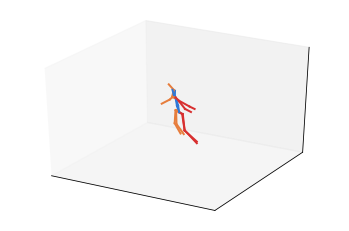

89.61099405887575


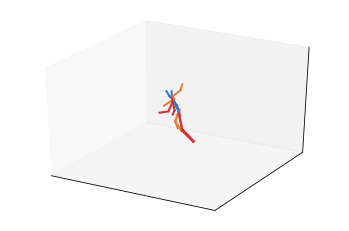

100.94574536674412


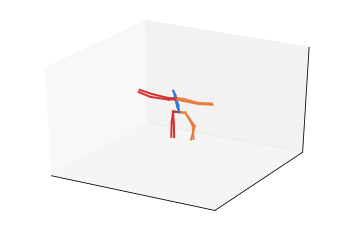

45.76228832898188


In [12]:
for i in range(3):
    i *= 10
    show3Dpose(np.array([mgt[i, ], mpred[i, ]]), MuPoTSJoints(), invert_vertical=True)
    plt.show()
    print(eval_results({'0': mgt[i:i+1, ]}, {'0': mpred[i:i+1]}, MuPoTSJoints(), verbose=False)[0]['0'])